In [ ]:
%load_ext autoreload
%autoreload 2

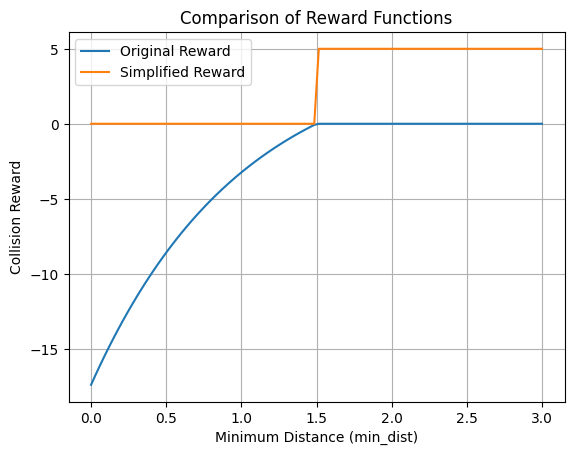

Simplified collision reward function created.
It provides zero reward when min_dist is at or below min_thresh and a constant reward of 5.0 beyond min_thresh.
This simplification maintains the core behavior of encouraging the robot to stay further than min_thresh while being computationally much cheaper.


In [51]:
import numpy as np

def simplified_coll_rew(min_dist, min_thresh):
  """
  Simplified collision reward function that approximates the original exponential form.

  Args:
    min_dist: Minimum distance from lidar feed.
    min_thresh: Threshold distance.

  Returns:
    Simplified collision reward.
  """
  if min_dist <= min_thresh:
    return 0.0  # Zero reward when too close or at threshold
  else:
    return 5.0 # Constant max reward when further than threshold

# Example Usage and comparison (optional, for demonstration)
min_thresh_example = 1.5 # Example threshold

# Original function
def original_coll_rew(min_dist, min_thresh):
  return np.clip(-5*np.exp(-(min_dist-min_thresh)), -np.inf, -5.0) + 5.0

# Test distances
test_distances = np.linspace(0, 3, 100) # Distances from 0 to 3

original_rewards = [original_coll_rew(dist, min_thresh_example) for dist in test_distances]
simplified_rewards = [simplified_coll_rew(dist, min_thresh_example) for dist in test_distances]

# --- Optional: To visualize the comparison (requires matplotlib) ---
import matplotlib.pyplot as plt
plt.plot(test_distances, original_rewards, label='Original Reward')
plt.plot(test_distances, simplified_rewards, label='Simplified Reward')
plt.xlabel('Minimum Distance (min_dist)')
plt.ylabel('Collision Reward')
plt.title('Comparison of Reward Functions')
plt.legend()
plt.grid(True)
plt.show()
# --- End of optional visualization ---


print("Simplified collision reward function created.")
print("It provides zero reward when min_dist is at or below min_thresh and a constant reward of 5.0 beyond min_thresh.")
print("This simplification maintains the core behavior of encouraging the robot to stay further than min_thresh while being computationally much cheaper.")

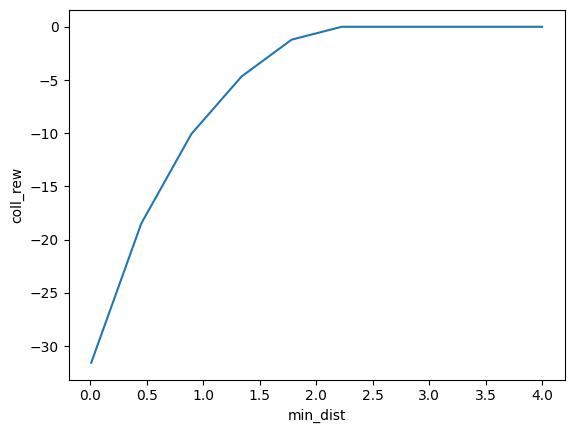

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# min_thresh = np.linspace(1.0, 2.0, 10)
min_thresh = 2.0
min_dist = np.linspace(0.01, 4.0, 10)
# coll_rew = np.clip((1/min_thresh - 10/min_dist), -30.0, 0.0)
coll_rew = np.clip(-5*np.exp(-(min_dist-min_thresh)), -np.inf, -5.0) + 5.0

plt.plot(min_dist, coll_rew, label='coll_rew_d')
plt.xlabel('min_dist')
plt.ylabel('coll_rew')
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
from stable_baselines3 import SAC
from stable_baselines3.common.preprocessing import get_action_dim

from env import PathFollowingEnv

from torch.cuda.amp import autocast, GradScaler
import math
import pandas as pd
from datetime import datetime

class ExpertDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.FloatTensor(observations)
        self.actions = torch.FloatTensor(actions)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx]

def generate_expert_data(env, n_episodes=1000, save_dir="expert_demonstrations"):
    """Generate expert demonstrations and save to CSV files"""
    
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    csv_file = os.path.join(save_dir, f'expert_data_{timestamp}.csv')
    
    columns = [
        'episode', 'step', 'success',
        'current_x', 'current_y',
        'goal_x', 'goal_y'
    ]
    for i in range(env.chunk_size):
        columns.extend([f'waypoint_{i}_x', f'waypoint_{i}_y'])
    columns.extend(['distance_to_goal', 'distance_to_next', 'timestep',
                   'action_linear', 'action_angular'])
    
    # Write header to CSV
    df = pd.DataFrame(columns=columns)
    df.to_csv(csv_file, index=False, header=True)
    
    successful_episodes = 0
    thresh = 0.1
    
    episode_pbar = tqdm(total=n_episodes, desc="Generating episodes", position=0)
    success_pbar = tqdm(total=n_episodes, desc="Successful episodes", position=1)
    
    try:
        for episode in range(n_episodes):
            episode_data = []
            
            obs = env.reset()[0]
            done = False
            truncated = False
            
            path = env.path_manager.get_full_path()
            
            # Skip if path is empty or too short
            if path is None or len(path) < 2:
                episode_pbar.update(1)
                continue
                
            current_pos = env.current_pos
            current_theta = env.agent_theta
            episode_success = False
            
            # Path following progress bar
            path_pbar = tqdm(total=len(path)-1, desc="Following path", 
                           position=2, leave=False)
            
            i = 0
            while i < (len(path) - 1):
                current_waypoint = path[i]
                distance = np.linalg.norm(current_waypoint - current_pos)

                if distance < thresh:
                    i += 1
                    path_pbar.update(1)
                    continue
                
                # Calculate expert action
                dx = current_waypoint[0] - current_pos[0]
                dy = current_waypoint[1] - current_pos[1]
                desired_theta = (np.arctan2(dy, dx) + np.pi) % (2 * np.pi) - np.pi
                
                angle_diff = desired_theta - current_theta
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
                
                # Generate expert action
                l = min(distance, 1.0) if abs(angle_diff) < np.pi/4 else 0.0
                theta = np.clip(angle_diff / np.pi, -1.0, 1.0)
                
                action = np.array([l, theta])
                
                # Store step data
                row = {
                    'episode': successful_episodes,
                    'step': env.current_step,
                    'success': False,  # Will update later if successful
                    'current_x': obs[0],
                    'current_y': obs[1],
                    'goal_x': obs[2],
                    'goal_y': obs[3],
                }
                
                # Add waypoints
                for j in range(env.chunk_size):
                    if 4 + j*2 + 1 < len(obs):  # Check if waypoint exists in observation
                        row[f'waypoint_{j}_x'] = obs[4 + j*2]
                        row[f'waypoint_{j}_y'] = obs[4 + j*2 + 1]
                    else:
                        row[f'waypoint_{j}_x'] = obs[-6]  # Use last valid waypoint
                        row[f'waypoint_{j}_y'] = obs[-5]
                
                # Add metrics
                row.update({
                    'distance_to_goal': obs[-3],
                    'distance_to_next': obs[-2],
                    'timestep': obs[-1],
                    'action_linear': action[0],
                    'action_angular': action[1]
                })
                
                episode_data.append(row)
                
                # Update environment
                obs, reward, done, truncated, info = env.step(action)
                
                if done or truncated:
                    episode_success = done
                    break
                    
                current_pos = env.current_pos
                current_theta = env.agent_theta
                path_pbar.update(1)
            
            path_pbar.close()
            
            # If episode completed successfully, save it
            if len(episode_data) > 0:
                # Update success flag for all steps in episode
                for step_data in episode_data:
                    step_data['success'] = True
                
                # Append to CSV file
                df = pd.DataFrame(episode_data)
                df.to_csv(csv_file, mode='a', header=False, index=False)
                
                successful_episodes += 1
                success_pbar.update(1)
                
                # Update progress bar postfix with stats
                success_pbar.set_postfix({
                    'len': len(episode_data),
                    'dist': f"{episode_data[-1]['distance_to_goal']:.3f}"
                })
            
            episode_pbar.update(1)
            episode_pbar.set_postfix({'success_rate': f"{successful_episodes/episode_pbar.n:.2%}"})
            
    finally:
        # Clean up progress bars
        episode_pbar.close()
        success_pbar.close()
    
    return csv_file

In [ ]:
def load_demonstrations(csv_file, env):
    """Load demonstrations from single CSV file"""
    world_max = np.array([8, 6])
    world_limits = np.array([[-8, 8], [-6, 6]])
    world_diag = np.linalg.norm(world_max)
    max_episode_timesteps = 200

    print(f"Loading demonstrations from {csv_file}")
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter successful episodes only
    df = df[df['success'] == True]

    df['current_x'] = df['current_x'] / world_max[0]
    df['current_y'] = df['current_y'] / world_max[1]
    df['goal_x'] = df['goal_x'] / world_max[0]
    df['goal_y'] = df['goal_y'] / world_max[1]
    for i in range(env.chunk_size):
        df[f'waypoint_{i}_x'] = df[f'waypoint_{i}_x'] / world_max[0]
        df[f'waypoint_{i}_y'] = df[f'waypoint_{i}_y'] / world_max[1]
    df['distance_to_goal'] = df['distance_to_goal'] / world_diag
    df['distance_to_next'] = df['distance_to_next'] / world_diag
    df['timestep'] = df['timestep'] / max_episode_timesteps

    # print(df.head())
    # Extract observations
    obs_cols = (
        ['current_x', 'current_y', 'goal_x', 'goal_y'] +
        [f'waypoint_{i}_x' for i in range(env.chunk_size)] +
        [f'waypoint_{i}_y' for i in range(env.chunk_size)] +
        ['distance_to_goal', 'distance_to_next', 'timestep']
    )
    
    # Extract actions
    action_cols = ['action_linear', 'action_angular']
    
    observations = df[obs_cols].values
    actions = df[action_cols].values
    
    return observations, actions

In [ ]:
# if __name__ == "__main__":
#     env = PathFollowingEnv(
#         image_path="standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
#         algo="SAC",
#         max_episode_steps=1000,
#         headless=True
#     )
    
#     # Generate demonstrations
#     csv_file = generate_expert_data(env, n_episodes=int(1e6), save_dir="/home/rahm/SIMPLE_LOGS/DATA")
    
#     # Load and verify the data
#     with tqdm(total=1, desc="Loading and verifying data") as pbar:
#         observations, actions = load_demonstrations(csv_file)
#         pbar.update(1)
#         pbar.set_postfix({
#             'obs_shape': observations.shape,
#             'act_shape': actions.shape
#         })

In [ ]:
# env = PathFollowingEnv(
#         image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
#         algo="SAC",
#         max_episode_steps=1000,
#         headless=False
#     )

In [ ]:
def pretrain_policy(
    env,
    policy,
    expert_data,
    device="cuda",
    batch_size=512,
    epochs=100,
    learning_rate=3e-4,
    val_split=0.1,
    early_stopping_patience=25,
):
    """Pretrain policy using behavioral cloning with optimized GPU implementation"""
    observations, actions = expert_data
    
    # Split data into train and validation sets
    split_idx = int(len(observations) * (1 - val_split))
    train_dataset = ExpertDataset(observations[:split_idx], actions[:split_idx])
    val_dataset = ExpertDataset(observations[split_idx:], actions[split_idx:])
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    optimizer = optim.AdamW(policy.parameters(), lr=learning_rate, weight_decay=1e-5)
    scaler = GradScaler()  # For mixed precision training
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    policy = policy.to(device)
    policy = torch.compile(policy)  # Using torch.compile for speedup
    
    for epoch in range(epochs):
        # Training phase
        policy.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for batch_obs, batch_actions in train_pbar:
            batch_obs = batch_obs.to(device, non_blocking=True)
            batch_actions = batch_actions.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Mixed precision training
            with torch.amp.autocast(device_type='cuda'):
                pred_actions = policy(batch_obs)
                loss = criterion(pred_actions[0], batch_actions)
            
            theta_error = criterion(pred_actions[0][:, 1], batch_actions[:, 1])
            # loss += theta_error
            wandb.log({"bc_train/theta_error": np.rad2deg(theta_error.item()*np.pi)})

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
            
            wandb.log({
                "bc_train/loss": loss.item(),
                "bc_train/learning_rate": optimizer.param_groups[0]['lr']
            })

        scheduler.step()

        # Validation phase
        policy.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        
        with torch.no_grad():
            for batch_obs, batch_actions in val_pbar:
                batch_obs = batch_obs.to(device, non_blocking=True)
                batch_actions = batch_actions.to(device, non_blocking=True)
                
                pred_actions = policy(batch_obs)
                loss = criterion(pred_actions[0], batch_actions)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.6f}'})

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        wandb.log({
            "bc_val/loss": avg_val_loss,
            "bc_train/avg_loss": avg_train_loss,
            "bc_train/epoch": epoch
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, "best_bc_policy.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    return policy

In [ ]:
from stable_baselines3 import SAC, PPO, TD3

def main():
    # Initialize wandb
    wandb.init(project="pretraining_BC", name="bc_pretraining_PPO")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner
    
    # Create environment
    env = PathFollowingEnv(
        image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
        algo="PPO",
        max_episode_steps=1000,
        headless=True,
        enable_wandb=False
    )
    
    # Generate expert demonstrations using RRT*
    csv_file = "/home/rahm/SIMPLE_LOGS/expert_data.csv"
    observations, actions = load_demonstrations(csv_file, env)
    expert_data = (observations, actions)

    # print(F"expert_data: {expert_data}")
    
    # Initialize new policy for pretraining
    policy = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        verbose=1,
        n_steps=2048,
        n_epochs=10,
        batch_size=64,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        device=device,
        policy_kwargs={
            "net_arch": dict(
                pi=[256, 512, 512, 256],
                qf=[256, 512, 512, 256]
            ),
            "optimizer_class": optim.AdamW,
            "optimizer_kwargs": dict(weight_decay=1e-5)
        }
    ).policy
    
    # Pretrain the policy
    pretrained_policy = pretrain_policy(
        env=env,
        policy=policy,
        expert_data=expert_data,
        batch_size=1024,
        epochs=100,
        learning_rate=3e-4,
        device=device
    )
    
    # Save the final pretrained policy
    torch.save({
        'model_state_dict': pretrained_policy.state_dict(),
        # 'final_loss': best_val_loss,
    }, "Nnew2_final_bc_policy.pth")
    
    wandb.finish()

if __name__ == "__main__":
    main()

In [ ]:
from stable_baselines3 import SAC, PPO, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from env import PathFollowingEnv

# Initialize wandb
wandb.init(project="pretraining_Eval", name="bc_pretraining_PPO")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner

# Create environment
env = PathFollowingEnv(
    image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
    algo="PPO",
    max_episode_steps=1000,
    headless=False,
    enable_wandb=False,
    enable_reward_monitor=True,
)

env.reset()

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device=device,
    policy_kwargs={
        "net_arch": dict(
            pi=[256, 512, 512, 256],
            qf=[256, 512, 512, 256]
        ),
        "optimizer_class": optim.AdamW,
        "optimizer_kwargs": dict(weight_decay=1e-5)
    }
)

saved_model = torch.load("New_final_bc_policy.pth")
saved_model['model_state_dict'] = {k.replace('_orig_mod.', ''): v for k, v in saved_model['model_state_dict'].items()}

model.policy.load_state_dict(saved_model['model_state_dict'])
evaluate_policy(model, env, n_eval_episodes=100, deterministic=True)

# Save the final pretrained policy
# torch.save({
#     'model_state_dict': pretrained_policy.state_dict(),
#     # 'final_loss': best_val_loss,
# }, "final_bc_policy.pth")

wandb.finish()

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import wandb
import argparse

from tqdm import tqdm
from stable_baselines3 import SAC
from stable_baselines3.common.preprocessing import get_action_dim
from stable_baselines3.common.noise import NormalActionNoise

from env import PathFollowingEnv

from torch.cuda.amp import autocast, GradScaler
import math
import pandas as pd
from datetime import datetime

class ExpertDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.FloatTensor(observations)
        self.actions = torch.FloatTensor(actions)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx]

def load_demonstrations(csv_file, env):
    """Load demonstrations from single CSV file"""
    world_max = np.array([8, 6])
    world_limits = np.array([[-8, 8], [-6, 6]])
    world_diag = np.linalg.norm(world_max)
    max_episode_timesteps = 200

    print(f"Loading demonstrations from {csv_file}")
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter successful episodes only
    df = df[df['success'] == True]

    df['current_x'] = df['current_x'] / world_max[0]
    df['current_y'] = df['current_y'] / world_max[1]
    df['goal_x'] = df['goal_x'] / world_max[0]
    df['goal_y'] = df['goal_y'] / world_max[1]
    for i in range(env.chunk_size):
        df[f'waypoint_{i}_x'] = df[f'waypoint_{i}_x'] / world_max[0]
        df[f'waypoint_{i}_y'] = df[f'waypoint_{i}_y'] / world_max[1]
    df['distance_to_goal'] = df['distance_to_goal'] / world_diag
    df['distance_to_next'] = df['distance_to_next'] / world_diag
    df['timestep'] = df['timestep'] / max_episode_timesteps

    # print(df.head())
    # Extract observations
    obs_cols = (
        ['current_x', 'current_y', 'goal_x', 'goal_y'] +
        [f'waypoint_{i}_x' for i in range(env.chunk_size)] +
        [f'waypoint_{i}_y' for i in range(env.chunk_size)] +
        ['distance_to_goal', 'distance_to_next', 'timestep']
    )
    
    # Extract actions
    action_cols = ['action_linear', 'action_angular']
    
    observations = df[obs_cols].values
    actions = df[action_cols].values
    
    return observations, actions

def pretrain_policy(
    env,
    policy,
    expert_data,
    device="cuda",
    batch_size=256,
    epochs=20,
    learning_rate=3e-4,
    val_split=0.1,
    early_stopping_patience=10,
):
    """Pretrain policy using behavioral cloning with optimized GPU implementation"""
    observations, actions = expert_data
    
    # Split data into train and validation sets
    split_idx = int(len(observations) * (1 - val_split))
    train_dataset = ExpertDataset(observations[:split_idx], actions[:split_idx])
    val_dataset = ExpertDataset(observations[split_idx:], actions[split_idx:])

    alpha = 0.4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=8,
        persistent_workers=True
    )

    optimizer = optim.AdamW(policy.parameters(), lr=learning_rate, weight_decay=1e-5)
    scaler = GradScaler()  # For mixed precision training
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    policy = policy.to(device)
    policy = torch.compile(policy)  # Using torch.compile for speedup
    
    for epoch in range(epochs):
        # Training phase
        policy.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for batch_obs, batch_actions in train_pbar:
            batch_obs = batch_obs.to(device, non_blocking=True)
            batch_actions = batch_actions.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Mixed precision training
            with torch.amp.autocast(device_type='cuda'):
                pred_actions = policy(batch_obs)
                loss_l = criterion(pred_actions[:, 0], batch_actions[:, 0])
                loss_theta = criterion(pred_actions[:, 1], batch_actions[:, 1])
                loss = alpha*loss_l + (1-alpha)*loss_theta

            theta_error = criterion(pred_actions[:, 1], batch_actions[:, 1])
            # loss += theta_error
            wandb.log({"bc_train/theta_error": np.rad2deg(theta_error.item()*np.pi)})

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
            
            wandb.log({
                "bc_train/loss": loss.item(),
                "bc_train/learning_rate": optimizer.param_groups[0]['lr']
            })

        scheduler.step()

        # Validation phase
        policy.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        
        with torch.no_grad():
            for batch_obs, batch_actions in val_pbar:
                batch_obs = batch_obs.to(device, non_blocking=True)
                batch_actions = batch_actions.to(device, non_blocking=True)
                
                pred_actions = policy(batch_obs)
                loss_l = criterion(pred_actions[:, 0], batch_actions[:, 0])
                loss_theta = criterion(pred_actions[:, 1], batch_actions[:, 1])
                loss = alpha*loss_l + (1-alpha)*loss_theta

                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.6f}'})

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        wandb.log({
            "bc_val/loss": avg_val_loss,
            "bc_train/avg_loss": avg_train_loss,
            "bc_train/epoch": epoch
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, "best_bc_policy.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    return policy

from stable_baselines3 import SAC, PPO, TD3

def main():
    # algo = args.algo.upper()
    # Initialize wandb
    # wandb.init(project="pretraining_BC", name=f"bc_pretraining_{algo}")
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner
    
    # Create environment
    env = PathFollowingEnv(
        image_path="/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png",
        algo_run="sac",
        max_episode_steps=1000,
        headless=True,
        enable_wandb=False
    )
    
    # Generate expert demonstrations using RRT*
    csv_file = "/home/rahm/SIMPLE_LOGS/expert_data.csv"
    observations, actions = load_demonstrations(csv_file, env)
    expert_data = (observations, actions)

    print(observations.shape)

    # # print(F"expert_data: {expert_data}")
    # policy_kwargs = {
    #             "net_arch": dict(
    #                 pi=[32, 64, 64, 64, 64, 64, 64, 64, 64],
    #                 qf=[32, 64, 64, 64, 64, 64, 64, 64, 64]
    #             ),
    #             "optimizer_class": optim.AdamW,
    #             "optimizer_kwargs": dict(weight_decay=1e-5)
    #         }
    
    # # Initialize new policy for pretraining
    # if algo.upper() == "PPO":
    #     policy = PPO(
    #         "MlpPolicy",
    #         env,
    #         learning_rate=3e-4,
    #         verbose=1,
    #         n_steps=2048,
    #         n_epochs=10,
    #         batch_size=64,
    #         gamma=0.99,
    #         gae_lambda=0.95,
    #         clip_range=0.2,
    #         ent_coef=0.01,
    #         vf_coef=0.5,
    #         max_grad_norm=0.5,
    #         normalize_advantage=True,
    #         device=device,
    #         policy_kwargs=policy_kwargs,
    #     ).policy
    # elif algo.upper() == "SAC":
    #     policy = SAC(
    #             "MlpPolicy",
    #             env,
    #             learning_rate=3e-4,
    #             buffer_size=1000000,
    #             batch_size=256,
    #             ent_coef='auto',
    #             gamma=0.99,
    #             tau=0.005,
    #             train_freq=1,
    #             gradient_steps=1,
    #             learning_starts=10000,
    #             policy_kwargs=policy_kwargs,
    #             device=device,
    #             verbose=1,
    #         ).policy
    # elif algo.upper() == "TD3":
    #     n_actions = env.action_space.shape[-1]
    #     action_noise = NormalActionNoise(
    #         mean=np.zeros(n_actions),
    #         sigma=0.1 * np.ones(n_actions)
    #     )

    #     policy = TD3(
    #             "MlpPolicy",
    #             env,
    #             learning_rate=0.001,
    #             buffer_size=1000000,
    #             learning_starts=100,
    #             batch_size=256,
    #             tau=0.005,
    #             gamma=0.99,
    #             train_freq=1,
    #             gradient_steps=1,
    #             action_noise=action_noise,
    #             policy_delay=2,
    #             target_policy_noise=0.2,
    #             target_noise_clip=0.5,
    #             device=device,
    #             verbose=1
    #         ).policy

    # # Pretrain the policy
    # pretrained_policy = pretrain_policy(
    #     env=env,
    #     policy=policy,
    #     expert_data=expert_data,
    #     batch_size=1024,
    #     epochs=100,
    #     learning_rate=3e-4,
    #     device=device
    # )
    
    # # Save the final pretrained policy
    # torch.save({
    #     'model_state_dict': pretrained_policy.state_dict(),
    #     # 'final_loss': best_val_loss,
    # }, "TD3_Pretrained.pth")
    
    # wandb.finish()

if __name__ == "__main__":
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--algo", type=str, default="td3", choices=["ppo", "sac", "td3"])
    # parser.add_argument("--csv", type=str, default="expert_data.csv")
    # args = parser.parse_args()

    main()

Loading demonstrations from /home/rahm/SIMPLE_LOGS/expert_data.csv
(11470274, 31)


In [3]:
import numpy as np

a = np.eye(3)
a

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from numba import jit

@jit(nopython=True)
def _ray_march(start_x, start_y, angle, resolution, max_distance, img_width, img_height, binary_img):
    """Optimized ray marching for a single ray using Numba"""
    dx = np.cos(angle)
    dy = -np.sin(angle)  # Negative because image coordinates are flipped vertically
    
    x, y = start_x, start_y
    distance = 0.0
    
    while 0 <= int(x) < img_width and 0 <= int(y) < img_height and distance < max_distance:
        if binary_img[int(y), int(x)] == 0:  # Hit an obstacle (black pixel)
            return distance
        x += dx * resolution
        y += dy * resolution
        distance += resolution
    
    return max_distance

def lidar_simulation_from_image(image_path, left_corner, right_corner, current_pos, goal_pos, resolution=1.0, fov=360, num_rays=360, max_distance=12.0):
    """
    Simulates SLAMTEC RPLiDAR A2 specifications:
    - Angular Resolution: 0.9° or 1°
    - Scanning Frequency: 10Hz
    - Range: 12m
    - Sample Duration: ~0.25ms per sample
    """

    img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
    binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
    binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)
    
    # Get image dimensions
    img_height, img_width = binary_img.shape
    
    # Calculate resolution scaling factors
    resolution_x = img_width / (right_corner[0] - left_corner[0])
    resolution_y = img_height / (right_corner[1] - left_corner[1])
    
    # Convert world coordinates to image coordinates
    img_x = int((current_pos[0] - left_corner[0]) * resolution_x)
    img_y = int((current_pos[1] - left_corner[1]) * resolution_y)
    
    # Initialize arrays for storing points
    angles = np.linspace(0, np.deg2rad(fov), num_rays, endpoint=False)
    distances = np.zeros(num_rays)
    
    # Ray march for each angle
    for i, angle in enumerate(angles):
        distances[i] = _ray_march(
            img_x, img_y, angle, 
            resolution, max_distance,
            img_width, img_height, 
            binary_img
        )
    
    # Convert distances and angles to cartesian coordinates (relative to robot)
    x_coords = distances * np.cos(angles)
    y_coords = distances * np.sin(angles)
    points = np.column_stack((x_coords, y_coords))
    
    # Scale points back to world coordinates
    points[:, 0] /= resolution_x
    points[:, 1] /= resolution_y
    
    return points

if __name__ == "__main__":
    image_path = "/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/TEST_FILES/New_WR_World.png"  # Replace with the path to your image
    resolution = 1  # Distance step in pixels
    left = (-10, 7)
    right = (10, -7)
    start = (0, -3.5)
    end = (5, -1)
    fov = 360
    num_rays = 720
    max_distance = 250
    lidar_simulation_from_image(image_path, left, right, start, end, resolution, fov, num_rays, max_distance)

In [ ]:
import numpy as np
import cv2
from numba import jit

@jit(nopython=True)
def _ray_march(start_x, start_y, angle, resolution, max_distance, img_width, img_height, binary_img):
    """Optimized ray marching for a single ray using Numba"""
    dx = np.cos(angle)
    dy = -np.sin(angle)  # Negative because image coordinates are flipped vertically
    
    x, y = start_x, start_y
    distance = 0.0
    
    while 0 <= int(x) < img_width and 0 <= int(y) < img_height and distance < max_distance:
        if binary_img[int(y), int(x)] == 0:  # Hit an obstacle (black pixel)
            return distance
        x += dx * resolution
        y += dy * resolution
        distance += resolution
    
    return max_distance

def lidar_simulation_from_image(binary_img, left_corner, right_corner, current_pos, goal_pos, resolution=1.0, fov=360, num_rays=360, max_distance=10.0):
    """
    Simulates SLAMTEC RPLiDAR A2 specifications:
    - Angular Resolution: 0.9° or 1°
    - Scanning Frequency: 10Hz
    - Range: 12m
    - Sample Duration: ~0.25ms per sample
    """
    # Get image dimensions
    img_height, img_width = binary_img.shape
    
    # Calculate resolution scaling factors
    resolution_x = img_width / (right_corner[0] - left_corner[0])
    resolution_y = img_height / (right_corner[1] - left_corner[1])
    
    # Convert world coordinates to image coordinates
    img_x = int((current_pos[0] - left_corner[0]) * resolution_x)
    img_y = int((current_pos[1] - left_corner[1]) * resolution_y)
    
    # Initialize arrays for storing points
    angles = np.linspace(0, np.deg2rad(fov), num_rays, endpoint=False)
    distances = np.zeros(num_rays)
    
    # Ray march for each angle
    for i, angle in enumerate(angles):
        distances[i] = _ray_march(
            img_x, img_y, angle, 
            resolution, max_distance,
            img_width, img_height, 
            binary_img
        )
    
    # Convert distances and angles to cartesian coordinates (relative to robot)
    x_coords = distances * np.cos(angles)
    y_coords = distances * np.sin(angles)
    points = np.column_stack((x_coords, y_coords))
    
    # Scale points back to world coordinates
    points[:, 0] /= resolution_x
    points[:, 1] /= resolution_y
    
    return points

def visualize_lidar(img_width, img_height, current_pos, lidar_points, world_to_img_func, color=(255, 0, 0), thickness=2):
    """
    Visualize LiDAR points on an image using cv2
    
    Args:
        img_width: Width of the visualization image
        img_height: Height of the visualization image
        current_pos: Current position of the robot in world coordinates
        lidar_points: Array of LiDAR points relative to robot position
        world_to_img_func: Function to convert world coordinates to image coordinates
        color: Color of LiDAR points (B,G,R)
        thickness: Thickness of LiDAR points
    """
    # Create visualization layer
    lidar_layer = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    
    if lidar_points is not None:
        # Convert robot position to image coordinates
        robot_img_pos = world_to_img_func(current_pos[0], current_pos[1])
        
        # Draw LiDAR rays
        for point in lidar_points:
            # Convert LiDAR point to world coordinates
            world_x = current_pos[0] + point[0]
            world_y = current_pos[1] + point[1]
            
            # Convert to image coordinates
            point_img_pos = world_to_img_func(world_x, world_y)
            
            # Draw line from robot to LiDAR point
            cv2.line(lidar_layer, robot_img_pos, point_img_pos, color, thickness)
            
            # Draw point at LiDAR hit
            cv2.circle(lidar_layer, point_img_pos, thickness+1, color, -1)
    
    return lidar_layer

def plot_lidar_polar(img_width, img_height, lidar_points, max_distance=12.0):
    """
    Create a polar plot of LiDAR data
    
    Args:
        img_width: Width of the plot
        img_height: Height of the plot
        lidar_points: Array of LiDAR points relative to robot position
        max_distance: Maximum LiDAR range
    """
    # Create polar plot image (black background)
    polar_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    
    # Draw circular grid
    center = (img_width // 2, img_height // 2)
    max_radius = min(img_width, img_height) // 2 - 20
    
    # Draw concentric circles
    num_circles = 4
    for i in range(1, num_circles + 1):
        radius = int(max_radius * i / num_circles)
        cv2.circle(polar_img, center, radius, (50, 50, 50), 1)
        # Add range label
        range_text = f"{max_distance * i / num_circles:.1f}m"
        cv2.putText(polar_img, range_text, 
                   (center[0] + radius + 5, center[1]), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 1)
    
    # Draw angle lines
    for angle in range(0, 360, 45):
        radian = np.deg2rad(angle)
        end_x = int(center[0] + max_radius * np.cos(radian))
        end_y = int(center[1] - max_radius * np.sin(radian))
        cv2.line(polar_img, center, (end_x, end_y), (50, 50, 50), 1)
        # Add angle label
        label_x = int(center[0] + (max_radius + 20) * np.cos(radian))
        label_y = int(center[1] - (max_radius + 20) * np.sin(radian))
        cv2.putText(polar_img, f"{angle}°", 
                   (label_x, label_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 1)
    
    if lidar_points is not None:
        # Plot LiDAR points
        for point in lidar_points:
            # Convert cartesian to polar coordinates
            distance = np.sqrt(point[0]**2 + point[1]**2)
            angle = np.arctan2(-point[1], point[0])  # Negative y for correct orientation
            
            # Scale distance to image size
            scaled_distance = (distance / max_distance) * max_radius
            
            # Convert to image coordinates
            x = int(center[0] + scaled_distance * np.cos(angle))
            y = int(center[1] - scaled_distance * np.sin(angle))
            
            # Draw point
            cv2.circle(polar_img, (x, y), 2, (0, 0, 255), -1)
    
    return polar_img

In [ ]:
def main():
    """Test function for LiDAR simulation and visualization"""
    # Parameters
    image_path = "New_WR_World.png"  # Replace with your image path
    img_width, img_height = 800, 600
    world_limits = ((-10, 8), (10, -8))  # (left_corner, right_corner)
    
    # Load and process the world image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    # Resize and threshold image
    img = cv2.resize(img, (img_width, img_height))
    binary_img = (img > 128).astype(np.uint8)
    
    # Create window for visualization
    cv2.namedWindow('LiDAR Test', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('LiDAR Test', img_width * 2, img_height)
    
    # Initial position and parameters
    current_pos = np.array([0.0, 0.0])
    goal_pos = np.array([5.0, 5.0])
    lidar_specs = [1, 360, 720, 12]  # [resolution, FOV, #Rays, max_distance]
    
    def world_to_img_left(x, y):
        """Convert world coordinates to left panel image coordinates"""
        img_x = int((x - world_limits[0][0]) * (img_width / (world_limits[1][0] - world_limits[0][0])))
        img_y = int((world_limits[0][1] - y) * (img_height / (world_limits[0][1] - world_limits[1][1])))
        return img_x, img_y

    def world_to_img_right(x, y):
        """Convert world coordinates to right panel image coordinates"""
        img_x = int((x - world_limits[0][0]) * (img_width / (world_limits[1][0] - world_limits[0][0]))) + img_width
        img_y = int((world_limits[0][1] - y) * (img_height / (world_limits[0][1] - world_limits[1][1])))
        return img_x, img_y

    # Main loop
    angle = 0.0
    running = True
    while running:
        # Create combined image
        combined_img = np.zeros((img_height, img_width * 2, 3), dtype=np.uint8)
        
        # Copy world image to both panels
        world_img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        combined_img[:, :img_width] = world_img_color
        combined_img[:, img_width:] = world_img_color
        
        # Update position (circular motion for testing)
        angle += 0.02
        current_pos = np.array([
            3.0 * np.cos(angle),
            3.0 * np.sin(angle)
        ])
        
        # Simulate LiDAR
        lidar_points = lidar_simulation_from_image(
            binary_img,
            world_limits[0],
            world_limits[1],
            current_pos,
            goal_pos,
            lidar_specs[0],
            lidar_specs[1],
            lidar_specs[2],
            lidar_specs[3]
        )
        
        # Draw LiDAR visualization on both panels
        lidar_layer_left = visualize_lidar(
            img_width, img_height,
            current_pos,
            lidar_points,
            world_to_img_left,
            color=(255, 0, 0),
            thickness=1
        )
        lidar_layer_right = visualize_lidar(
            img_width, img_height,
            current_pos,
            lidar_points,
            world_to_img_right,
            color=(255, 0, 0),
            thickness=1
        )
        
        # Blend LiDAR visualization
        combined_img[:, :img_width] = cv2.addWeighted(
            combined_img[:, :img_width], 1.0,
            lidar_layer_left, 0.7,
            0
        )
        combined_img[:, img_width:] = cv2.addWeighted(
            combined_img[:, img_width:], 1.0,
            lidar_layer_right, 0.7,
            0
        )
        
        # Add polar plot
        polar_size = 200
        polar_plot = plot_lidar_polar(
            polar_size, polar_size,
            lidar_points,
            max_distance=lidar_specs[3]
        )
        
        # Place polar plot in top-right corner
        margin = 10
        combined_img[margin:margin+polar_size, 
                    img_width*2-polar_size-margin:img_width*2-margin] = polar_plot
        
        # Draw robot position
        robot_pos_left = world_to_img_left(current_pos[0], current_pos[1])
        robot_pos_right = world_to_img_right(current_pos[0], current_pos[1])
        cv2.circle(combined_img, robot_pos_left, 5, (0, 255, 255), -1)  # Yellow dot
        cv2.circle(combined_img, robot_pos_right, 5, (0, 255, 255), -1)  # Yellow dot
        
        # Draw goal position
        goal_pos_left = world_to_img_left(goal_pos[0], goal_pos[1])
        goal_pos_right = world_to_img_right(goal_pos[0], goal_pos[1])
        cv2.circle(combined_img, goal_pos_left, 5, (0, 255, 0), -1)  # Green dot
        cv2.circle(combined_img, goal_pos_right, 5, (0, 255, 0), -1)  # Green dot
        
        # Add text overlay
        info_text = [
            f"Position: ({current_pos[0]:.2f}, {current_pos[1]:.2f})",
            f"Angle: {np.degrees(angle):.1f}°",
            f"LiDAR points: {len(lidar_points)}",
            "Press 'Q' to quit"
        ]
        
        for i, text in enumerate(info_text):
            cv2.putText(combined_img, text, (10, 30 + i * 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Show the combined image
        cv2.imshow('LiDAR Test', combined_img)
        
        # Handle keyboard input
        key = cv2.waitKey(30) & 0xFF
        if key == ord('q'):
            running = False
    
    # Cleanup
    cv2.destroyAllWindows()
    cv2.waitKey(1)

if __name__ == "__main__":
    main()